# Churn Prediction 

### Imports

In [24]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

### Reading data and initial EDA

In [26]:
data = pd.read_csv("takehome_ds_written.csv")

In [27]:
data.head()

,Unnamed: 0,merchant,time,amount_usd_in_cents
0,1,faa029c6b0,2034-06-17 23:34:14,6349
1,2,ed7a7d91aa,2034-12-27 00:40:38,3854
2,3,5608f200cf,2034-04-30 01:29:42,789
3,4,15b1a0d61e,2034-09-16 01:06:23,4452
4,5,4770051790,2034-07-22 16:21:42,20203


In [28]:
print(data.shape)
print(data.merchant.nunique())

(1513719, 4)
14351


### There are around 1.5 million transactions 
### 14351 merchants

### Identifying merchants 

In [29]:
df = data.groupby('merchant').size().sort_values(ascending=False)
df

merchant
5608f200cf    25512
53b3fbeae2    12178
1ddaea9838    12042
89e2d29885    11969
654930c922    11222
              ...  
9847b12953        1
985bf67891        1
9865dca5a3        1
988269b4df        1
80240af3ef        1
Length: 14351, dtype: int64

In [30]:
a = data.groupby(['merchant'])['amount_usd_in_cents'].agg('sum').sort_values(ascending=False)

In [31]:
df = a.to_frame()
df.head()

,amount_usd_in_cents
merchant,
44ee3ec72c,236907231
bdebc6831e,218808567
654930c922,151116295
ce61387781,142905563
82897075ed,110573229


### convert the amount USD in cents to a round figure

In [32]:
df["USD"] = df["amount_usd_in_cents"]/100
df["USD"] = df["USD"].astype(int)
df["hundred"] = df["USD"]/100
df["hundred"] = df["hundred"].astype(int)
df["nearest_100"] = df["hundred"] - df["hundred"]%100
df["nearest_100"] = df["nearest_100"].astype(int)
df.head()
# df["nearest_100"].value_counts()

,amount_usd_in_cents,USD,hundred,nearest_100
merchant,,,,
44ee3ec72c,236907231,2369072,23690,23600
bdebc6831e,218808567,2188085,21880,21800
654930c922,151116295,1511162,15111,15100
ce61387781,142905563,1429055,14290,14200
82897075ed,110573229,1105732,11057,11000


<Figure size 1440x432 with 0 Axes>

<AxesSubplot:xlabel='nearest_100', ylabel='count'>

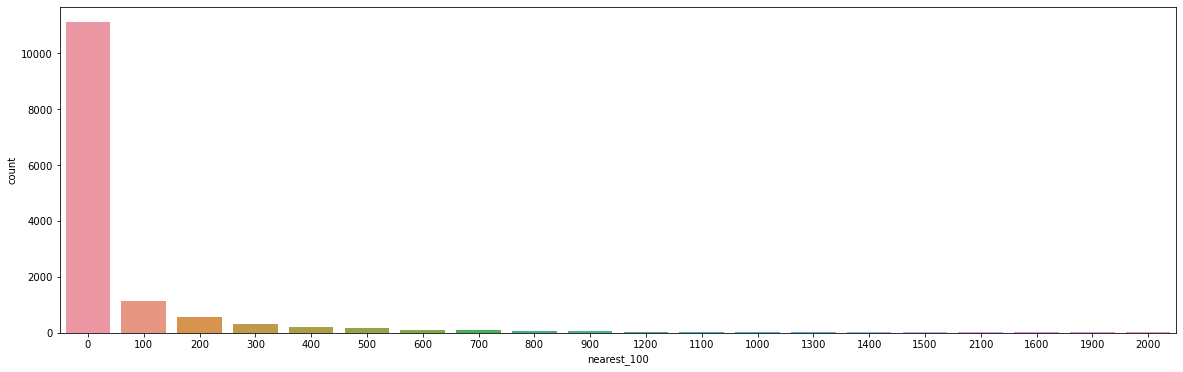

In [33]:
plt.figure(figsize=(20,6)) 
sns.countplot(df["nearest_100"], order=pd.value_counts(df["nearest_100"]).iloc[:20].index)
plt.show()

### A majority of the merchants have spent under 100 USD over the period of 2 years

### Lets check the frequency now

In [34]:
freq = data.groupby(['merchant'])['time'].agg('count').sort_values(ascending=False)
# freq.shape
df_freq = freq.to_frame()
df_freq.head()

,time
merchant,
5608f200cf,25512
53b3fbeae2,12178
1ddaea9838,12042
89e2d29885,11969
654930c922,11222


<Figure size 864x432 with 0 Axes>

<AxesSubplot:xlabel='time', ylabel='count'>

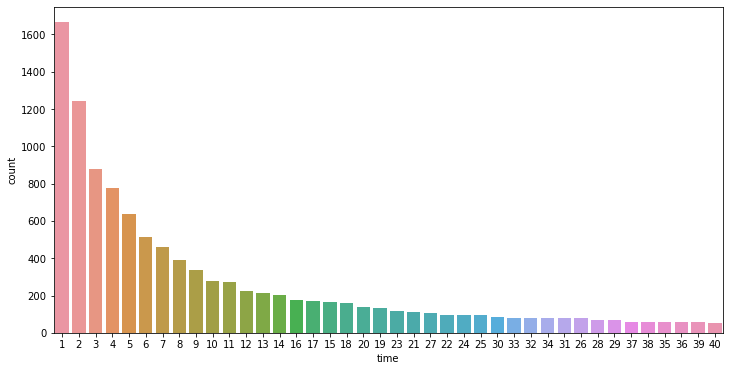

In [72]:
plt.figure(figsize=(12,6)) 
sns.countplot(df_freq["time"], order=pd.value_counts(df_freq["time"]).iloc[:40].index)
plt.show()

### Out of 14351 merchants, around 1600+ merchants have transacted only once

In [37]:
df_freq[df_freq["time"] ==1].shape

(1666, 1)

#### Lets join the merchant-amount dataframe with merchant-frequency

In [38]:
df_mer_freq_amt = pd.merge(df, df_freq, on="merchant")
# df_mer_freq_amt.head()
df_mer_freq_amt[["USD", "nearest_100", "time"]].head()

,USD,nearest_100,time
merchant,,,
44ee3ec72c,2369072,23600,4973
bdebc6831e,2188085,21800,6180
654930c922,1511162,15100,11222
ce61387781,1429055,14200,3389
82897075ed,1105732,11000,4210


In [39]:
import pandas as pd
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

# dfTest = pd.DataFrame({'A':[14.00,90.20,90.95,96.27,91.21],
#                            'B':[103.02,107.26,110.35,114.23,114.68],
#                            'C':['big','small','big','small','small']})

df_mer_freq_amt_scaled = df_mer_freq_amt[['nearest_100', 'time']]
df_mer_freq_amt_scaled = scaler.fit_transform(df_mer_freq_amt_scaled[['nearest_100', 'time']])

df_mer_freq_amt_scaled

array([[36.82931704,  9.22403938],
       [34.00371314, 11.51132564],
       [23.48618752, 21.06600447],
       ...,
       [-0.21748961, -0.19798821],
       [-0.21748961, -0.19798821],
       [-0.21748961, -0.19798821]])

### Plotting the nearest_100 and time 

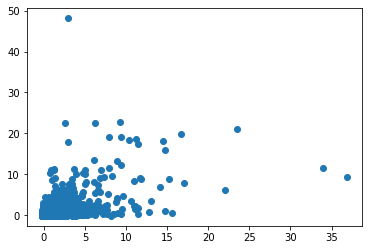

In [40]:
plt.plot(df_mer_freq_amt_scaled[:, 0], df_mer_freq_amt_scaled[:, 1], 'o', label = 'data')

### This plot is not helping in clustering the merchants. Lets try another approach


## RFM

I recently came across an intuitive segmentation approach called RFM (Recency Frequency Monetary Value), which can be easily applied to basic merchant transaction records.  

#### About RFM Segmentation  

Here’s what each letter of RFM means: 

**Recency** : How long has it been since the merchant last purchased using stripe (e.g. in days, in months)?  
In our case we will calculate the number of days between the most recent transaction and the first transaction of the merchant with Stripe  

**Frequency** : How many times has the merchant purchased using stripe within a fixed period (e.g. past 3 months, past year)   
In our case, we will calculate the number of repeat transactions = (count of all transactions by merchant to date - 1)

**Monetary Value** : How much has the merchant spent at stripe within a fixed period (which should be the same period set for Frequency)   
In our case, we will calculate the total money spent by the merchant on all transactions

For the purposes of this unsupervised data analysis that might involve non-subsription based transactional data,
we will use the lifetimes package that relies on the recency-frequency-monetary (RFM) analysis to model churn and customer lifetime value (CLV)
#### recency   = number of days between the most recent transaction and the first transaction of the merchant with Stripe
#### frequency = number of repeat transactions = (count of all transactions by merchant to date - 1)
#### monetary   = Total money spent by the merchant on all transactions
#### T = It is the age of the customer in whatever time units chosen (daily, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.

In [41]:
transactions = pd.read_csv('takehome_ds_written.csv')

In [42]:
transactions.head()

,Unnamed: 0,merchant,time,amount_usd_in_cents
0,1,faa029c6b0,2034-06-17 23:34:14,6349
1,2,ed7a7d91aa,2034-12-27 00:40:38,3854
2,3,5608f200cf,2034-04-30 01:29:42,789
3,4,15b1a0d61e,2034-09-16 01:06:23,4452
4,5,4770051790,2034-07-22 16:21:42,20203


In [44]:
transactions['time'] = pd.to_datetime(transactions['time']).dt.date

In [45]:
from lifetimes.utils import *
from lifetimes import BetaGeoFitter,GammaGammaFitter
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix, plot_period_transactions, plot_cumulative_transactions,plot_incremental_transactions

In [46]:
# Creating a RFM data frame for the merchant
rfmdf = summary_data_from_transaction_data(transactions,'merchant','time',
                                           monetary_value_col='amount_usd_in_cents',)

In [47]:
rfmdf.head(10)

,frequency,recency,T,monetary_value
merchant,,,,
0002b63b92,0.0,0.0,594.0,0.000000
0002d07bba,3.0,65.0,81.0,27909.666667
00057d4302,1.0,66.0,580.0,9135.000000
000bcff341,0.0,0.0,509.0,0.000000
000ddbf0ca,0.0,0.0,577.0,0.000000
000ed1585f,57.0,656.0,681.0,28345.070175
000f8c3297,147.0,457.0,458.0,23348.993197
001f7b7a4f,0.0,0.0,304.0,0.000000
0020aefbd9,1.0,23.0,215.0,9415.000000


### Lets look deeper in the RMF data for random merchant - 0002d07bba

In [48]:
m = transactions[transactions.merchant.str.contains('0002d07bba')]
m.sort_values(by='time').head(10)

,Unnamed: 0,merchant,time,amount_usd_in_cents
1123972,1123973,0002d07bba,2034-10-11,5549
835993,835994,0002d07bba,2034-10-17,37830
891755,891756,0002d07bba,2034-11-13,43842
874950,874951,0002d07bba,2034-12-15,2057


In [49]:
rfmdf[rfmdf.index.str.contains('0002d07bba')].head()

,frequency,recency,T,monetary_value
merchant,,,,
0002d07bba,3.0,65.0,81.0,27909.666667


### frequency - This means that the merchant '0002d07bba' has transacted with stripe 3 times after first transaction. 
### recency - The merchant has 65 days gap between most recent transaction and first transaction
### monetary value - The merchant spent USD 279 using stripe
### T - The age of the customer is 81 days


### Exploring merchant spending

In [57]:
mcg=pd.DataFrame(transactions.groupby('merchant').size().sort_values(ascending=False))

In [58]:
mcg.head()

,0
merchant,
5608f200cf,25512
53b3fbeae2,12178
1ddaea9838,12042
89e2d29885,11969
654930c922,11222


(array([1.4264e+04, 5.7000e+01, 1.6000e+01, 6.0000e+00, 7.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 2.55210e+03, 5.10320e+03, 7.65430e+03, 1.02054e+04,
        1.27565e+04, 1.53076e+04, 1.78587e+04, 2.04098e+04, 2.29609e+04,
        2.55120e+04]),
 <BarContainer object of 10 artists>)

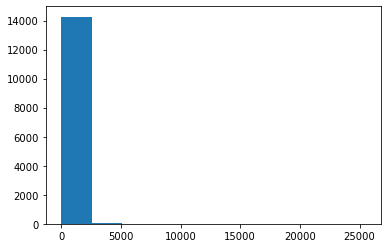

In [59]:
plt.hist(mcg)

### It looks like a handful of merchants contribute to the majority of transactions as the plot is skewed

### Let's see how many merchants have more than 100 transactions

In [60]:
mcg.rename( columns={0:'count'}, inplace=True )
mcg[mcg["count"] > 1000].shape

(275, 1)

In [61]:
mcg[mcg["count"] > 100].shape

(2194, 1)

#### There are only 275 merchants with more than 1000 transactions and 2,194 merchants with more than 100 transactions.
#### This confirms that the majority of merchants are either new or are churning after a few transactions

### I'm going to use the Beta-Geometric/NBD (BG/NBD) model for customer churn. 

#### The BG/NBD model is an adaptation of the Pareto/NBD model. Both models describe repeat purchasing patterns in businesses where customer turnover is unobserved; however, the BG/NBD is much more computationally feasible.


## Assumptions of the BG/NBD model:
##### 1. A customer’s (here merchant's) relationship has two phases: “alive” for an unobserved period of time, then “dead” (churned)
##### 2. While alive, the number of transactions made by a customer follows a Poisson distribution with transaction rate of lambda
##### 3. Heterogeneity in lambda follows a gamma distribution
##### 4. After any transaction, a customer dies with probability p;
##### 5. The probability that a customer dies after a number of transactions follows a geometric distribution
##### 6. p follows a beta distribution
##### 7. Lambda and p vary independently across customers
##### Source 1: http://brucehardie.com/papers/bgnbd_2004-04-20.pdf
##### Source 2: https://medium.com/data-shopify/how-shopify-merchants-can-measure-retention-c12284bfed6f

### Lets visualize the RMF data

###  We can visualize the frequency/recency matrix, which computes the expected number of transactions a merchant is to make in the next time period, given their recency (age at last purchase) and frequency (the number of repeat transactions they have made).

In [55]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(rfmdf['frequency'], rfmdf['recency'], rfmdf['T']);

/Users/anoushkagade/opt/anaconda3/lib/python3.8/site-packages/lifetimes/fitters/beta_geo_fitter.py:256: RuntimeWarning: overflow encountered in double_scalars
  denominator = 1 + (x > 0) * (a / (b + x - 1)) * ((alpha + T) / (alpha + recency)) ** (r + x)


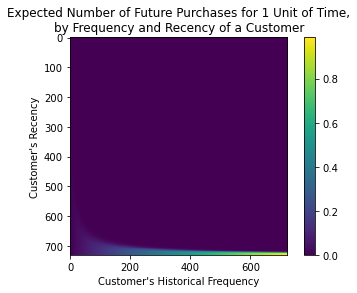

In [56]:
plot_frequency_recency_matrix(bgf);

### We can see that if a merchant has used stripe 600 times, and their latest purchase was when they were 700 days (or more) old (given the merchant is 700 days old), then they are your best merchant (bottom-right)

### The model expects future purchase activity from merchants with frequency>600 and recency > 700 (number of days the merchant has been with stripe excluding their first transaction)

### A)  Concrete definition of churn 
#### churn =  The percentage rate of merchants that have stopped using stripe. 

### B) Identify merchants that have already churned in the dataset 
#### The subset of merchants with recency < 600 and frequency <100 and T > 600 

#### (I'm avoiding those merchants that started using stripe late. They will unnecesarily fall in the "churned category" )

In [62]:
rfmdf[(rfmdf["recency"] < 600) & (rfmdf["frequency"] < 100) & (rfmdf["T"] > 600)].head(20)

,frequency,recency,T,monetary_value
merchant,,,,
007364b02a,2.0,236.0,653.0,20341.500000
00cd72cf0e,8.0,588.0,649.0,31384.000000
0125d43ba4,2.0,2.0,615.0,2664.000000
013cc2cd06,4.0,65.0,676.0,9202.750000
0149d4bfba,15.0,76.0,623.0,12584.800000
0150c59efd,15.0,586.0,611.0,8212.266667
0155692eb6,5.0,596.0,608.0,271.000000
01874bc7cf,1.0,5.0,633.0,22896.000000
026c361940,1.0,84.0,632.0,200652.000000


## Lets see the data for merchants that we have predicted as 'churned'

### Merchant : 045a1c428b

### RFM matrix

In [63]:
rfmdf[rfmdf.index.str.contains('045a1c428b')].head()

,frequency,recency,T,monetary_value
merchant,,,,
045a1c428b,45.0,438.0,711.0,155058.222222


### Actual Transactions - Latest 5 and first 5

In [64]:
m = transactions[transactions.merchant.str.contains('045a1c428b')]
m.sort_values(by='time', ascending=False).head()
m.sort_values(by='time', ascending=False).tail()

,Unnamed: 0,merchant,time,amount_usd_in_cents
489834,489835,045a1c428b,2034-04-02,26645
526092,526093,045a1c428b,2034-03-15,15960
291431,291432,045a1c428b,2034-03-01,28261
1363526,1363527,045a1c428b,2034-02-04,29005
1325682,1325683,045a1c428b,2034-02-04,26645


,Unnamed: 0,merchant,time,amount_usd_in_cents
1413337,1413338,045a1c428b,2033-01-19,39465
1410694,1410695,045a1c428b,2033-01-19,39465
547192,547193,045a1c428b,2033-01-19,39741
1033343,1033344,045a1c428b,2033-01-19,39465
629505,629506,045a1c428b,2033-01-19,39465


### As we can see above, the merchant's last activity was in Apr 2034. After that no activity for the rest of 2034 This merchant has "churned"

## Lets verify for merchants that have *not churned*

In [65]:
rfmdf[(rfmdf["recency"] > 600) & (rfmdf["frequency"] > 100)].head(10)

,frequency,recency,T,monetary_value
merchant,,,,
00a6d31535,210.0,658.0,659.0,28905.661905
039fb73850,217.0,712.0,713.0,63430.755760
044ebe709c,326.0,690.0,690.0,1448.346626
068da9961c,141.0,601.0,617.0,16402.574468
06e69bee48,232.0,724.0,725.0,116520.362069
08ee7ca022,336.0,711.0,711.0,32204.211310
09a5e17225,241.0,613.0,614.0,24145.643154
0b3b179a82,126.0,616.0,647.0,159526.817460
0b4ce03036,238.0,624.0,625.0,7148.907563


### Lets see the data for merchant '00a6d31535'

### RFM

In [66]:
rfmdf[rfmdf.index.str.contains('00a6d31535')].head()

,frequency,recency,T,monetary_value
merchant,,,,
00a6d31535,210.0,658.0,659.0,28905.661905


### Actual Transactions -- Latest 5 and first 5

In [67]:
m = transactions[transactions.merchant.str.contains('00a6d31535')]
m.sort_values(by='time', ascending=False).head()
m.sort_values(by='time', ascending=False).tail()

,Unnamed: 0,merchant,time,amount_usd_in_cents
1092200,1092201,00a6d31535,2034-12-30,9105
1074021,1074022,00a6d31535,2034-12-30,3753
871312,871313,00a6d31535,2034-12-28,8361
795428,795429,00a6d31535,2034-12-21,46963
133970,133971,00a6d31535,2034-12-21,43828


,Unnamed: 0,merchant,time,amount_usd_in_cents
1061642,1061643,00a6d31535,2033-03-12,30435
563187,563188,00a6d31535,2033-03-12,33760
431396,431397,00a6d31535,2033-03-12,7819
759244,759245,00a6d31535,2033-03-12,60144
277456,277457,00a6d31535,2033-03-12,25486


### As we can see here, the merchant started transacting in march 2033, and latest transaction was in december 2034. So this merchant has definitely not churned

## C) build a model to predict which active merchants are most likely to churn in the near future


### For this I will use plot_probability_alive_matrix , which gives the probability a customer is alive based on their frequency and recency.

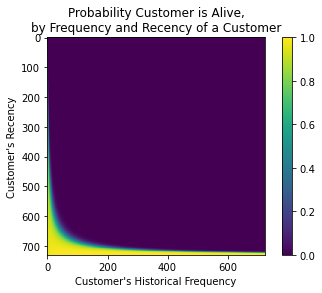

In [68]:
plot_probability_alive_matrix(bgf);

### The sweet spot for merchants that are highly probable to make another transaction with stripe (shown in the above plot are merchants whose probability is >0.6 

### To predict active merchants are most likely to churn in the near future, I will take a subset of those merchants whose frequency and recency values fit into the plot above with probability <0.6

## Limitations of this study
### 1. The BG/NBD model used here assumes a 0% churn probability for the merchant who hasn't had a repeat transaction.
###   Therefore, we need to exclude those merchants from this study who have had only 1 transaction till date